# Code

## Imports

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from elasticsearch import Elasticsearch, NotFoundError
from haystack import Document, Pipeline
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchBM25Retriever
from haystack.components.converters import TextFileToDocument
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.utils import Secret
from huggingface_hub import login

In [2]:
load_dotenv(find_dotenv())
login(token=os.environ["HUGGINGFACEHUB_API_TOKEN"])

## Section 3: Building an Exam Preparation Chatbot using RAG

### Q3.1: Load Class Transcripts into Elasticsearch

In [3]:
client = Elasticsearch(
    hosts=os.environ.get("ES_LOCAL_URL"),
    basic_auth=(os.environ.get("ELASTIC_SEARCH_USERNAME"), os.environ.get("ELASTIC_SEARCH_PASSWORD"))
)

In [4]:
index_name = "lecture_transcripts"
try:
    client.indices.delete(index=index_name)
except NotFoundError:
    print("Index doesn't exist!")
client.indices.create(index=index_name)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'lecture_transcripts'})

In [5]:
document_store = ElasticsearchDocumentStore(
    hosts=os.environ.get("ES_LOCAL_URL"),
    basic_auth=(os.environ.get("ELASTIC_SEARCH_USERNAME"), os.environ.get("ELASTIC_SEARCH_PASSWORD")),
    index=index_name
)

In [6]:
transcript_directory = "transcripts/transcripts"
transcript_files = [
    os.path.join(transcript_directory, transcript_filename)
    for transcript_filename in os.listdir(transcript_directory)
]
index_pipeline = Pipeline()
index_pipeline.add_component("converter", TextFileToDocument())
index_pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=150))
index_pipeline.add_component("writer", DocumentWriter(document_store))
index_pipeline.connect("converter", "splitter")
index_pipeline.connect("splitter", "writer")
index_pipeline.run({"converter": {"sources": transcript_files}})

{'writer': {'documents_written': 901}}

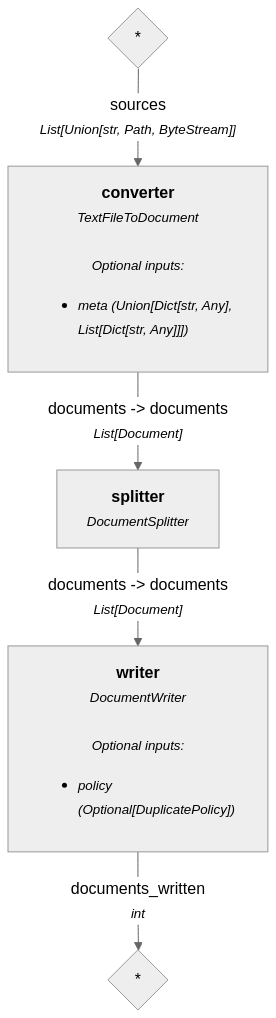

In [7]:
index_pipeline.show()

### Q3.2: Implement the Streamlit App

In [8]:
template = """
<|system|>
You are a helpful assistant.<|end|>
<|user|>
Given the following information, answer the question.

Context: 
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ query }}?<|end|>
<|assistant|>"""

In [9]:
retriever = ElasticsearchBM25Retriever(document_store=document_store)
generator = HuggingFaceAPIGenerator(
    api_type="serverless_inference_api",
    api_params={
        "model": "microsoft/Phi-3.5-mini-instruct", 
        "max_new_tokens": 200
    }
)

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


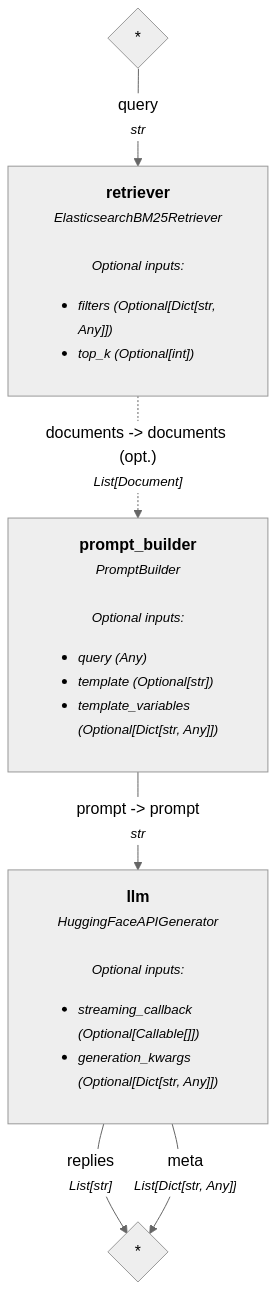

In [10]:
rag_pipeline = Pipeline()
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipeline.add_component("llm", generator)
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.show()

In [11]:
def run_rag(query):
    assert rag_pipeline is not None
    res = rag_pipeline.run({
        "prompt_builder": {
            "query": query
        },
        "retriever": {
            "query": query
        }
    })
    return res['llm']['replies'][0]

In [12]:
query = "Explain the core topics taught in this course?"
response = run_rag(query=query)
print(response)

/home/badri/miniconda3/lib/python3.12/site-packages/huggingface_hub/inference/_client.py:2288: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


The core topics taught in this course, CS 639: Data Management for Data Science, include:

1. Data Warehouses and Data Lakes: Understanding the differences between these two types of data storage systems and their role in managing large volumes of data.

2. Semantic Layer and Knowledge Graph: Learning about the concept of a semantic layer, which helps in organizing and structuring data, and knowledge graphs, which represent relationships between data entities.

3. Apache Iceberg System: Exploring Apache Iceberg, a columnar data storage system that enables efficient data management and analysis.

4. ETL vs. ELT: Understanding the differences between Extract, Transform, Load (ETL) and Extract, Load, Transform (ELT) processes, and how they are used in building data pipelines.

5. Predictive Analysis: Learning about boosting techniques and time series analysis for making predictions based on data.

6. Vector Databases and Prompt Engineering: Exploring vector databases for storing and query

In [13]:
%reset -f

In [14]:
%%writefile app.py

import os
from dotenv import load_dotenv, find_dotenv
from elasticsearch import Elasticsearch, NotFoundError
from haystack import Document, Pipeline
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchBM25Retriever
from haystack.components.converters import TextFileToDocument
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.utils import Secret
from huggingface_hub import login
import streamlit as st

load_dotenv(find_dotenv())
login(token=os.environ["HUGGINGFACEHUB_API_TOKEN"])

client = Elasticsearch(
    hosts=os.environ.get("ES_LOCAL_URL"),
    basic_auth=(os.environ.get("ELASTIC_SEARCH_USERNAME"), os.environ.get("ELASTIC_SEARCH_PASSWORD"))
)

index_name = "lecture_transcripts"
try:
    client.indices.delete(index=index_name)
except NotFoundError:
    print("Index doesn't exist!")
client.indices.create(index=index_name)

document_store = ElasticsearchDocumentStore(
    hosts=os.environ.get("ES_LOCAL_URL"),
    basic_auth=(os.environ.get("ELASTIC_SEARCH_USERNAME"), os.environ.get("ELASTIC_SEARCH_PASSWORD")),
    index=index_name
)

transcript_directory = "transcripts/transcripts"
transcript_files = [
    os.path.join(transcript_directory, transcript_filename)
    for transcript_filename in os.listdir(transcript_directory)
]
index_pipeline = Pipeline()
index_pipeline.add_component("converter", TextFileToDocument())
index_pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=150))
index_pipeline.add_component("writer", DocumentWriter(document_store))
index_pipeline.connect("converter", "splitter")
index_pipeline.connect("splitter", "writer")
index_pipeline.run({"converter": {"sources": transcript_files}})

template = """
<|system|>
You are a helpful assistant.<|end|>
<|user|>
Given the following information, answer the question.

Context: 
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ query }}?<|end|>
<|assistant|>"""

retriever = ElasticsearchBM25Retriever(document_store=document_store)
generator = HuggingFaceAPIGenerator(
    api_type="serverless_inference_api",
    api_params={
        "model": "microsoft/Phi-3.5-mini-instruct", 
        "max_new_tokens": 200
    }
)

rag_pipeline = Pipeline()
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipeline.add_component("llm", generator)
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

st.title("💬 Course Chatbot")
st.caption("🚀 Interactive Q&A with Elasticsearch, Haystack, and HuggingFace")

if "messages" not in st.session_state:
    st.session_state.messages = []

for msg in st.session_state.messages:
    st.chat_message(msg["role"]).write(msg["content"])

if prompt := st.chat_input("Ask a question about the course transcripts"):
    st.session_state.messages.append({"role": "user", "content": prompt})
    st.chat_message("user").write(prompt)
    response = rag_pipeline.run({
        "retriever": {"query": prompt},
        "prompt_builder": {"query": prompt}
    })['llm']['replies'][0]

    st.session_state.messages.append({"role": "assistant", "content": response})
    st.chat_message("assistant").write(response)

Overwriting app.py


In [15]:
! curl https://loca.lt/mytunnelpassword

34.59.47.167

In [ ]:
! streamlit run app.py & lt --port 8501

your url is: https://spotty-ducks-matter.loca.lt



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.128.0.7:8501
  External URL: http://34.59.47.167:8501

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
2025-05-07 16:09:42.837 Examining the path of torch.classes raised:
Traceback (most recent call last):
  File "/home/badri/miniconda3/lib/python3.12/site-packages/streamlit/web/bootstrap.py", line 347, in run
    if asyncio.get_running_loop().is_running():
       ^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: no running event loop

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/badri/minico

### Q3.3: Compare Fine-Tuning vs RAG

- Ran the above script for the RAG.
- Ran the fine-tuned model in `p6.ipynb` for the same set of prompts.
- Results from the fine-tuned model can be seen in `p6.ipynb`

- **More accurate responses:** RAG was more accurate because it retrieved factual, up-to-date information from external sources.
- **Hallucination in fine-tuned model:** The fine-tuned model hallucinated due to limited training scope and lack of real-time knowledge.
- **RAG on unseen questions:** RAG handled unseen questions better since it dynamically pulls relevant context instead of relying solely on learned patterns.